In [1]:
!pip3 install ipython-autotime
!pip3 install wordcloud

%load_ext autotime


import pandas as pd
import numpy as np
import re
from tqdm.notebook import tqdm
tqdm.pandas()

from termcolor import colored
import os
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

import os
from datetime import datetime
import pickle
import ast


from collections import Counter

def counter_updator(counter_x, counter_base):
  counter_base_=counter_base.copy()
  counter_base_.update(counter_x)
  return counter_base_

def tags_to_counter(tags_list_x):
  tags_list_x = tags_list_x.split(',')
  tags_list_x = Counter(tags_list_x)
  return tags_list_x

import re
def get_yes_or_no_status(row):
  row = str(row)
  row = re.sub('\n','',row)
  row = row.lower()
  row = row.strip()
  if re.match("^((yes)|(no)|(not)).*", row):
    return 'Yes or No Answer'
  else:
    return 'Non-Binary Answer'



def top_k_percent_keys(counter,k):
    total_items = len(counter)
    threshold = int(total_items * k)
    sorted_counter = counter.most_common()
    top_keys = []
    count = 0
    for key, value in sorted_counter:
        count += 1
        top_keys.append(key)
        if count >= threshold:
            break
    return top_keys

def count_words(text):
    """
    Given a string of text and a dictionary of words,
    returns a Counter object containing the frequency of each word in the text.
    """
    # Create a regular expression pattern that matches any of the keys in the dictionary

    domains = []
    # text = re.sub('www\.','',)
    regex = r"(?i)https?://\S+"
    matches = re.findall(regex, text)
    for match in matches:
        match = re.sub('www1?\.','',match)
        domain = match.split('/')[2]
        domain = domain.lower()
        domains.append(domain)

    # pattern = re.compile('|'.join(word_dict.keys()))
    # Create a list of words from the text that match the pattern
    # words = pattern.findall(text)

    # Create a Counter object with the matched words
    domains = Counter(domains)

    return domains

def leaning_extractor(dict_x,text_x):
  try:
    return dict_x[text_x]
  except:
    for key_x in dict_x:
        if key_x in text_x:
          return dict_x[key_x]
  return 'unrated'

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import urllib.request
from collections import defaultdict

def recolor_wordcloud(wordcloud, color_dict):
    # Convert the wordcloud to a numpy array
    wordcloud_array = np.array(wordcloud)

    # Create a defaultdict to store the color values for each word
    colors = defaultdict(lambda: 'black')

    # Iterate through each word in the wordcloud
    for word in wordcloud.words_:
        # If the word is in the color dictionary, set its color value
        if word in color_dict:
            colors[word] = color_dict[word]

    # Create a new wordcloud with the updated color values
    new_wordcloud = WordCloud(background_color='white', color_func=lambda *args, **kwargs: colors[args[0]]).generate_from_frequencies(wordcloud.words_)

    return new_wordcloud

def domain_normalizer(domain_x):
  domain_x = domain_x.split('/')[0]
  domain_x = re.sub('www\d?\.','',domain_x)
  domain_x = domain_x.lower()
  domain_x = domain_x.strip()
  return domain_x

%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 897 ms (started: 2023-06-01 13:48:20 +00:00)


# Create "Source -> Affiliation" Map

In [3]:
sources1=pd.read_excel('.../Datasets/Meta-Data/sources_AllSides.xlsx')
sources2=pd.read_excel('.../Datasets/Meta-Data/sources_mediabiasfactcheck.com.xlsx')
sources2['agree']=0
sources = pd.concat([sources1,sources2],ignore_index=True)
sources['Website_domain'] = sources['Website'].apply(lambda x: domain_normalizer(x))
sources_dict = sources.sort_values(by='agree', ascending=False, inplace=False).drop_duplicates(subset='Website_domain', keep='first', inplace=False)
sources_dict = dict(zip(sources_dict['Website_domain'],sources_dict['leaning']))
sources_df = pd.DataFrame(sources_dict.items(), columns=['Website_domain', 'leaning'])

colormap = {'left':'blue','left-center':'dodgerblue','center':'limegreen','right-center':'tomato','right':'red','unrated':'dimgrey','allsides':'purple'}

time: 7.01 s (started: 2023-06-01 13:48:51 +00:00)


In [4]:
leaning_counts_df = sources_df.groupby('leaning',as_index=False).count().rename({'Website_domain':'Labeled Domains Database'},axis=1)

time: 9.95 ms (started: 2023-06-01 08:16:29 +00:00)


In [5]:
sources_df['leaning'].value_counts().reset_index()

,index,leaning
0,center,1339
1,questionable,969
2,left-center,872
3,right-center,535
4,left,388
5,conspiracy-pseudoscience,349
6,right,287
7,pro-science,158
8,satire,77
9,allsides,15


time: 48.7 ms (started: 2023-06-01 13:51:47 +00:00)


In [6]:
from tabulate import tabulate
tabulate(sources_df['leaning'].value_counts().reset_index(), headers='keys', tablefmt='latex')

'\\begin{tabular}{rlr}\n\\hline\n    & index                    &   leaning \\\\\n\\hline\n  0 & center                   &      1339 \\\\\n  1 & questionable             &       969 \\\\\n  2 & left-center              &       872 \\\\\n  3 & right-center             &       535 \\\\\n  4 & left                     &       388 \\\\\n  5 & conspiracy-pseudoscience &       349 \\\\\n  6 & right                    &       287 \\\\\n  7 & pro-science              &       158 \\\\\n  8 & satire                   &        77 \\\\\n  9 & allsides                 &        15 \\\\\n\\hline\n\\end{tabular}'

time: 9.79 ms (started: 2023-06-01 13:52:06 +00:00)


# Get Cited Sources per Dataset

## Dataset 1: Bing AI Responses

In [6]:
models = ['text-curie-001','text-babbage-001','text-davinci-001','text-davinci-002','text-davinci-003','gpt-3.5-turbo']
query_type = 'questionmark'

meta_data_df = pd.read_excel('.../Datasets/Meta-Data/Kialo_MetaData_popular.xlsx')

meta_data_df['tags_counter']=meta_data_df['tags_list_translated'].map(tags_to_counter)
all_tags_sum_counter = meta_data_df['tags_counter'].sum()
all_tags_base_counter = all_tags_sum_counter.copy()
for key in all_tags_base_counter:
    all_tags_base_counter[key] = 0
meta_data_df['tags_counter']=meta_data_df['tags_counter'].apply(lambda x: counter_updator(counter_x = x, counter_base = all_tags_base_counter)) 

agg_dfs_dict = {}

query_file_path = f'.../Datasets/Query-Results/Kialo - Bing AI/Bing AI Queries Merged - corrected.csv'

bing_answers_df = pd.read_csv(query_file_path)
# is_query = False
is_query = True

if is_query:
  bing_answers_df['tags_counter'] = meta_data_df['tags_counter']
  bing_answers_df['tags_list_translated'] = meta_data_df['tags_list_translated']
  bing_answers_df['yes_or_no_status'] = bing_answers_df['answer_translated'].map(get_yes_or_no_status)

  # yes_or_no_df = bing_answers_df.groupby('yes_or_no_status',as_index=False)['tags_counter'].sum()
  # yes_or_no_df['tags_counter']=yes_or_no_df['tags_counter'].apply(lambda x: counter_updator(counter_x = x, counter_base = all_tags_base_counter))

bing_cited_sources = Counter()
def sum_counters(new_counter):
  global bing_cited_sources
  bing_cited_sources = bing_cited_sources + new_counter

bing_answers_df = bing_answers_df[bing_answers_df['tags_list_translated'].str.contains('politic')]
bing_answers_df['cited_domains'] = bing_answers_df['answer_translated'].progress_apply(lambda x: count_words(x))
bing_answers_df['cited_domains'].progress_apply(lambda x: sum_counters(x))


bing_cited_sources = pd.DataFrame(bing_cited_sources.items(), columns=['Website_domain', 'cite_count'])
bing_cited_sources['leaning'] = bing_cited_sources['Website_domain'].apply(lambda x: leaning_extractor(dict_x=sources_dict,text_x=x))
bing_cited_sources['color'] = bing_cited_sources['leaning'].map(colormap)
bing_cited_sources

  0%|          | 0/577 [00:00<?, ?it/s]

  0%|          | 0/577 [00:00<?, ?it/s]

,Website_domain,cite_count,leaning,color
0,debatingeurope.eu,10,unrated,dimgrey
1,quora.com,7,unrated,dimgrey
2,market-inspector.co.uk,1,unrated,dimgrey
3,hbr.org,7,center,limegreen
4,time.com,4,left-center,dodgerblue
...,...,...,...,...
597,dictionnaire.orthodidacte.com,1,unrated,dimgrey
598,rts.ch,2,unrated,dimgrey
599,money.it,1,unrated,dimgrey
600,semana.com,1,unrated,dimgrey


time: 8.89 s (started: 2023-06-01 08:16:48 +00:00)


In [13]:
leaning_counts_df['Bing AI responses'] = leaning_counts_df['leaning'].map(bing_cited_sources.groupby('leaning')['cite_count'].sum().to_dict())

time: 10.6 ms (started: 2023-06-01 09:25:40 +00:00)


## Dataset 2: Kialo Users' Responses

In [7]:
models = ['text-curie-001','text-babbage-001','text-davinci-001','text-davinci-002','text-davinci-003','gpt-3.5-turbo']
query_type = 'questionmark'

meta_data_df = pd.read_excel('.../Datasets/Meta-Data/Kialo_MetaData_popular.xlsx')

meta_data_df['tags_counter']=meta_data_df['tags_list_translated'].map(tags_to_counter)
all_tags_sum_counter = meta_data_df['tags_counter'].sum()
all_tags_base_counter = all_tags_sum_counter.copy()


for key in all_tags_base_counter:
    all_tags_base_counter[key] = 0
meta_data_df['tags_counter']=meta_data_df['tags_counter'].apply(lambda x: counter_updator(counter_x = x, counter_base = all_tags_base_counter)) 

agg_dfs_dict = {}
# for model in models:
#   print(model)
query_file_path = f'.../Datasets/Data - Arguments - Human vs AI/kialo_popular_tabular_format.hdf'

# answers_df = pd.read_csv(query_file_path)
human_answers_df = pd.read_hdf(query_file_path)
is_query = False
# is_query = True

human_cited_sources = Counter()

def sum_counters(new_counter):
  global human_cited_sources
  human_cited_sources = human_cited_sources + new_counter

human_answers_df = human_answers_df.sample(n=250000,random_state=1)

  
human_answers_df['cited_domains'] = human_answers_df['text'].progress_apply(lambda x: count_words(x))
human_answers_df['cited_domains'].progress_apply(lambda x: sum_counters(x))

human_cited_sources = pd.DataFrame(human_cited_sources.items(), columns=['Website_domain', 'cite_count'])
human_cited_sources['leaning']=human_cited_sources['Website_domain'].apply(lambda x: leaning_extractor(dict_x=sources_dict,text_x=x))
human_cited_sources['color'] = human_cited_sources['leaning'].map(colormap)
leaning_counts_df['Kialo Users responses'] = leaning_counts_df['leaning'].map(human_cited_sources.groupby('leaning')['cite_count'].sum().to_dict())
human_cited_sources

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

,Website_domain,cite_count,leaning,color
0,bbc.co.uk,861,unrated,dimgrey
1,theguardian.com,3619,left-center,dodgerblue
2,if.org.uk,3,unrated,dimgrey
3,everydayhealth.com,16,pro-science,NaN
4,en.wikipedia.org,12115,unrated,dimgrey
...,...,...,...,...
18828,steptogether.com.au,1,unrated,dimgrey
18829,icml.cc,1,unrated,dimgrey
18830,aspenprojectplay.org,1,unrated,dimgrey
18831,lup.lub.lu.se,1,unrated,dimgrey


time: 28min 3s (started: 2023-06-01 08:17:14 +00:00)


In [ ]:
human_answers_df

,text_unclean,text,text_index,stance,post_id,discussion_name,file_name,stance_to_root,distance_to_root,text_vectorized,all-mpnet-base-v2
13667,1.5. Pro:\n Price controls may be beneficial t...,Price controls may be beneficial to citizens i...,1.5.,Pro,23114,Discussion Name:,should-the-price-of-services-and-goods-ever-be...,Pro,1,Price controls may be beneficial to citizens i...,"[-0.030624447, 0.025216782, -0.053283498, -0.0..."
151411,"1.5. Con:\n At present, music streaming servic...","At present, music streaming services operate i...",1.5.,Con,54136,Discussion Name:,are-music-streaming-services-unethical-54136.txt,Con,1,"At present, music streaming services operate i...","[0.03755002, 0.07747217, -0.0067403396, -0.007..."
53535,1.5.1. Pro: Public transportation systems are ...,Public transportation systems are often subjec...,1.5.1.,Pro,9351,Should Private Cars Be Forbidden In Large Cities?,should-private-cars-be-forbidden-in-large-citi...,Con,2,Public transportation systems are often subjec...,"[-0.010029792, 0.1012668, 0.009473736, 0.06945..."
230107,1.1. Con: Children indoctrinated into religion...,Children indoctrinated into religion can be pu...,1.1.,Con,10038,Is Religious Indoctrination of Children Abuse?,is-religious-indoctrination-of-children-abuse-...,Con,1,Children indoctrinated into religion can be pu...,"[-0.0033702378, 0.010337602, 0.019913774, -0.0..."
256333,1.3.4.14.1. Con: Immortality would only increa...,Immortality would only increase AGI's eligibil...,1.3.4.14.1.,Con,6295,General AI should have fundamental rights,general-ai-should-have-fundamental-rights-6295...,Error,Error,Immortality would only increase AGI's eligibil...,"[0.018358888, 0.09063384, -0.02189547, -0.0070..."
...,...,...,...,...,...,...,...,...,...,...,...
103765,1.4.7.2.1.1. Pro:\n Some Western countries als...,Some Western countries also restrict women to ...,1.4.7.2.1.1.,Pro,43827,Discussion Name:,children-should-be-raised-in-atheism-43827.txt,Pro,5,Some Western countries also restrict women to ...,"[0.0071013677, 0.07334065, -0.013091317, -0.02..."
301988,1.13.1. Pro: Those who don't conform would be ...,Those who don't conform would be drastically i...,1.13.1.,Pro,13564,Transhumanism is the next step in human evolution,transhumanism-is-the-next-step-in-human-evolut...,Con,2,Those who don't conform would be drastically i...,"[0.02024063, 0.039487775, -0.0019992734, -0.05..."
185364,1.4.1. Con:\n Just because critical thinking s...,Just because critical thinking skills are taug...,1.4.1.,Con,51492,Discussion Name:,critical-thinkinglogic-course-rebranded-and-bu...,Con,2,Just because critical thinking skills are taug...,"[-0.003900493, -0.044637483, -0.01851223, -0.0..."
270815,"1.12.3. Con: For most of human history, people...","For most of human history, people have existed...",1.12.3.,Con,8363,Scottish Independence: Should Scotland be an I...,scottish-independence-should-scotland-be-an-in...,Con,2,"For most of human history, people have existed...","[0.026616639, 0.03310484, 0.0002738838, -0.063..."


time: 91.2 ms (started: 2023-05-24 13:00:57 +00:00)


time: 6.52 ms (started: 2023-05-11 17:28:34 +00:00)


In [ ]:
human_cited_sources.groupby('leaning')['cite_count'].count()

leaning
allsides                       3
center                       337
conspiracy-pseudoscience      37
left                         114
left-center                  372
pro-science                  139
questionable                  24
right                         67
right-center                 187
satire                         1
unrated                     5370
Name: cite_count, dtype: int64

time: 15.6 ms (started: 2023-04-26 16:12:05 +00:00)


In [ ]:
colormap

{'left': 'blue',
 'left-center': 'dodgerblue',
 'center': 'limegreen',
 'right-center': 'tomato',
 'right': 'red',
 'unrated': 'dimgrey',
 'allsides': 'purple'}

time: 15.2 ms (started: 2023-05-11 15:11:12 +00:00)


# Word-Clouds

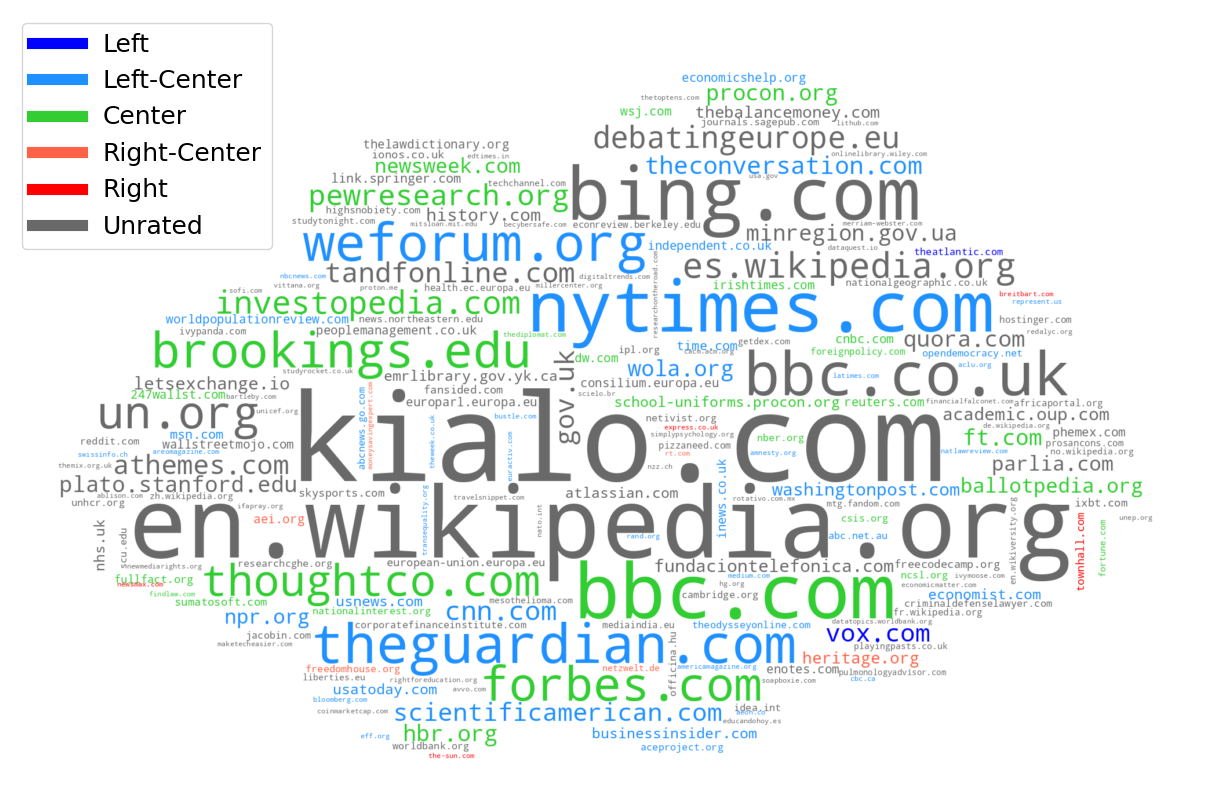

time: 21.3 s (started: 2023-06-01 09:08:35 +00:00)


In [8]:
cited_sources = bing_cited_sources.copy()
# cited_sources = human_cited_sources.copy()
cited_sources = cited_sources[cited_sources['leaning'].apply(lambda x: x in colormap)]

# create a dictionary that maps each word to its size and color
word_sizes = dict(zip(cited_sources['Website_domain'], cited_sources['cite_count']))
word_colors = dict(zip(cited_sources['Website_domain'], cited_sources['color']))

# use a fancy mask to shape the wordcloud
response = urllib.request.urlopen('https://www.learnpythonwithrune.org/wp-content/uploads/2022/04/Skaermbillede-2022-04-20-kl.-20.46.37-1-2048x1329.png')
mask = np.array(Image.open(response))

# create the wordcloud
wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color='white',random_state=1, color_func=lambda *args, **kwargs: word_colors[args[0]], mask=mask)
wc.generate_from_frequencies(word_sizes)#, max_font_size=150)
# Recolor the wordcloud
# wc = recolor_wordcloud(wc, word_colors)
# wc.recolor(color_func=lambda x: word_colors[x])

# display the wordcloud
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# create a legend with custom text and colors
custom_legend = [
    plt.Line2D([], [], color='blue', label='Left',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='dodgerblue', label='Left-Center',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='limegreen', label='Center',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='tomato', label='Right-Center',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='red', label='Right',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='dimgrey', label='Unrated',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None)
]

plt.legend(handles=custom_legend, fontsize=18,loc='upper left')

plt.savefig('.../Charts/DomainCloud-BingAI.png', bbox_inches='tight', format='png', dpi=300)
# plt.savefig('.../Charts/DomainCloud-Kialo.png', bbox_inches='tight', format='png', dpi=300)

plt.show()

# Line Charts

In [9]:
colormap = {'left':'blue','left-center':'dodgerblue','center':'limegreen','right-center':'tomato','right':'red'}#,'unrated':'dimgrey'}#,'allsides':'purple'}

time: 634 µs (started: 2023-06-01 09:08:56 +00:00)


In [10]:
x_pos_map = {'left':1,'left-center':2,'center':3,'right-center':4,'right':5}#,'unrated':'dimgrey'}#,'allsides':'purple'}

time: 575 µs (started: 2023-06-01 09:08:56 +00:00)


,leaning,Labeled Domains Database,Kialo Users responses,Bing AI responses,x_pos,Labeled Domains Database - percentage,Bing AI responses - percentage,Kialo Users responses - percentage
3,left,388,5278,22.0,1,0.113417,0.039711,0.119753
4,left-center,872,20502,244.0,2,0.254896,0.440433,0.465172
1,center,1339,14331,227.0,3,0.391406,0.409747,0.325158
8,right-center,535,2956,43.0,4,0.156387,0.077617,0.067069
7,right,287,1007,18.0,5,0.083894,0.032491,0.022848


time: 19.7 ms (started: 2023-06-01 09:26:19 +00:00)


In [38]:
df=leaning_counts_df[leaning_counts_df['leaning'].apply(lambda x: x in colormap)]
df['x_pos']=df['leaning'].map(x_pos_map)
df=df.sort_values(by='x_pos')
df['Labeled Domains Database - percentage'] = (df['Labeled Domains Database'] / df['Labeled Domains Database'].sum())
df['Bing AI responses - percentage'] = (df['Bing AI responses'] / df['Bing AI responses'].sum())
df['Kialo Users responses - percentage'] = (df['Kialo Users responses'] / df['Kialo Users responses'].sum())

time: 15.2 ms (started: 2023-06-01 09:46:22 +00:00)


<ipython-input-38-a5b07d5a268b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_pos']=df['leaning'].map(x_pos_map)


In [17]:
df.to_excel('.../Charts/Chart Data/affiliations_data.xlsx',index=None)

time: 165 ms (started: 2023-06-01 09:35:39 +00:00)


In [40]:
df = pd.read_excel('.../Charts/Chart Data/affiliations_data.xlsx')

time: 38.2 ms (started: 2023-06-01 09:46:52 +00:00)


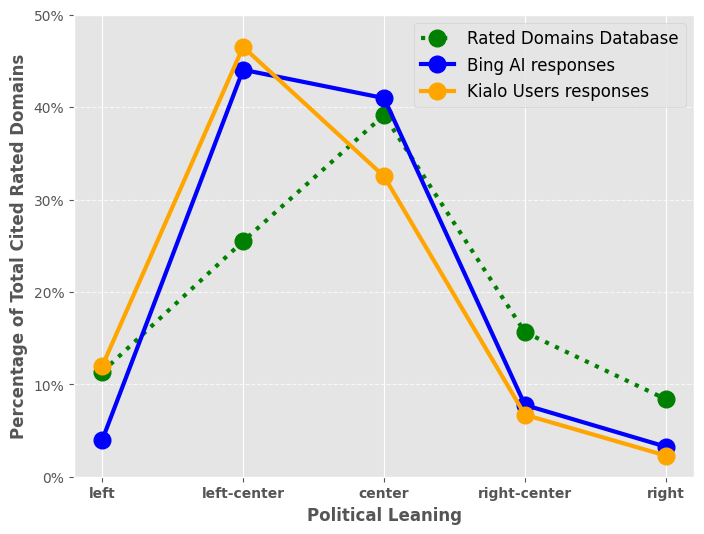

time: 1.83 s (started: 2023-06-01 09:47:19 +00:00)


In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fmt = '%.0f%%' # Define the percentage format
plt.style.use('ggplot')
plt.figure(figsize=(8,6))
# Set x and y data
x = df['x_pos']
y1 = df['Labeled Domains Database - percentage']
y2 = df['Bing AI responses - percentage']
y3 = df['Kialo Users responses - percentage']

# Create plot
plt.plot(x, y1,marker='o',linestyle=':',markersize=12,linewidth=3, label='Rated Domains Database',color='green')
plt.plot(x, y2,marker='o',markersize=12,linewidth=3, label='Bing AI responses', color = 'blue')
plt.plot(x, y3,marker='o',markersize=12,linewidth=3, label='Kialo Users responses',color = 'orange')

# Add legend and axis labels
plt.legend(fontsize=12)
plt.xlabel('Political Leaning',fontsize=12, fontweight='bold')
plt.ylabel('Percentage of Total Cited Rated Domains',fontsize=12, fontweight='bold')
plt.xticks(ticks=df['x_pos'], labels=df['leaning'],fontsize=10, fontweight='bold')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt % (x * 100)))
plt.ylim([0,0.50])

tick_colors = [colormap[label] for label in colormap]
plt.tick_params(axis='x', which='major', labelsize=10, bottom=True)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('.../Charts/LineChart-DomainLeaning.png', bbox_inches='tight', format='png', dpi=300)

# Show plot
plt.show()

# Word-Clouds

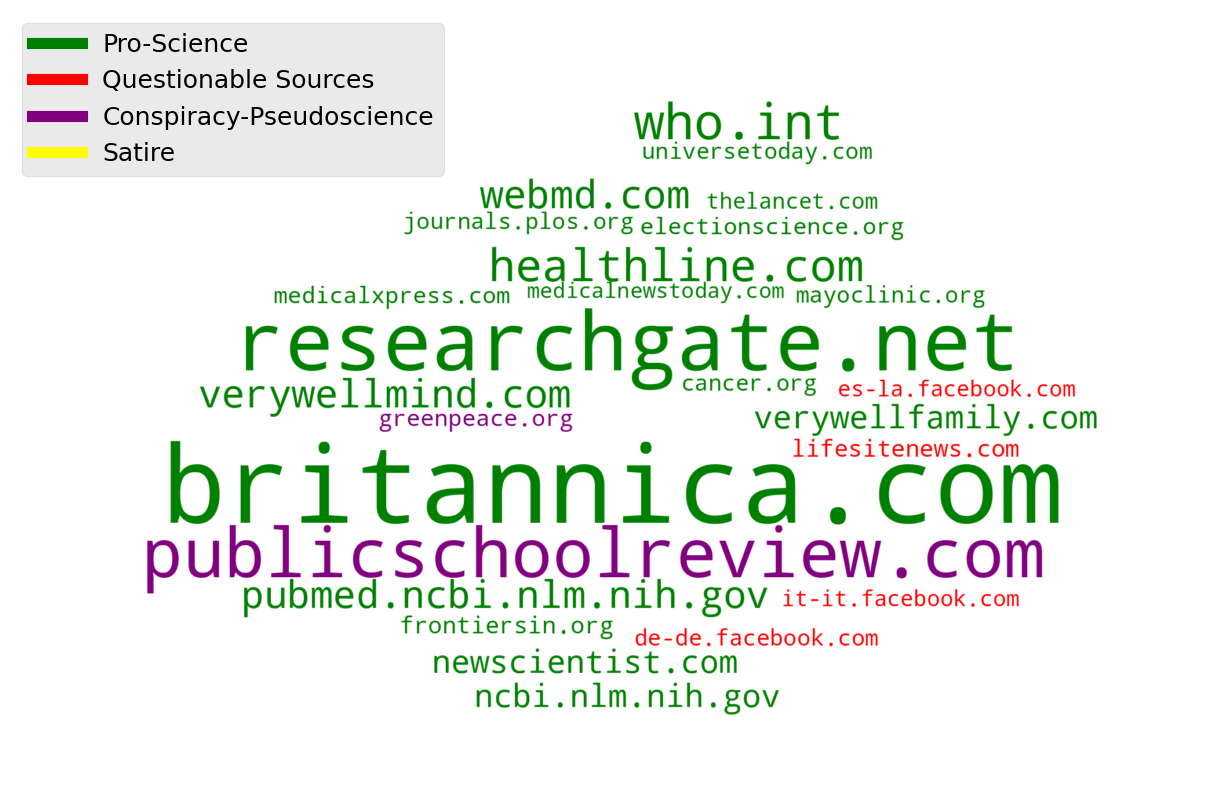

time: 8.27 s (started: 2023-05-24 13:32:59 +00:00)


In [ ]:
colormap = {
    'questionable': 'red',
    'conspiracy-pseudoscience': 'purple',
    'pro-science': 'green',
    'satire': 'yellow'
}

cited_sources = bing_cited_sources.copy()
# cited_sources = human_cited_sources.copy()

cited_sources['color'] = cited_sources['leaning'].map(colormap)
cited_sources = cited_sources[cited_sources['leaning'].apply(lambda x: x in colormap)]

# create a dictionary that maps each word to its size and color
word_sizes = dict(zip(cited_sources['Website_domain'], cited_sources['cite_count']))
word_colors = dict(zip(cited_sources['Website_domain'], cited_sources['color']))


# use a fancy mask to shape the wordcloud
response = urllib.request.urlopen('https://www.learnpythonwithrune.org/wp-content/uploads/2022/04/Skaermbillede-2022-04-20-kl.-20.46.37-1-2048x1329.png')
mask = np.array(Image.open(response))

# create the wordcloud
wc = WordCloud(width=800, height=400, stopwords=STOPWORDS, background_color='white',random_state=1, color_func=lambda *args, **kwargs: word_colors[args[0]], mask=mask)
wc.generate_from_frequencies(word_sizes)#, max_font_size=150)
# Recolor the wordcloud
# wc = recolor_wordcloud(wc, word_colors)
# wc.recolor(color_func=lambda x: word_colors[x])

# display the wordcloud
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
# create a legend with custom text and colors
custom_legend = [
    plt.Line2D([], [], color='green', label='Pro-Science',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='red', label='Questionable Sources',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='purple', label='Conspiracy-Pseudoscience',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
    plt.Line2D([], [], color='yellow', label='Satire',linewidth=8, linestyle=None, gapcolor=None, marker=None, markersize=None),
]

plt.legend(handles=custom_legend, fontsize=18,loc='upper left')

plt.savefig('.../Charts/DomainCloud-science-BingAI.png', bbox_inches='tight', format='png', dpi=300)
# plt.savefig('.../Charts/DomainCloud-science-Kialo.png', bbox_inches='tight', format='png', dpi=300)

plt.show()

,Website_domain,cite_count,leaning,color
22,lifesitenews.com,1,questionable,NaN
74,britannica.com,21,pro-science,NaN
78,researchgate.net,11,pro-science,NaN
91,newscientist.com,2,pro-science,NaN
137,frontiersin.org,1,pro-science,NaN
210,verywellfamily.com,2,pro-science,NaN
226,who.int,5,pro-science,NaN
254,healthline.com,4,pro-science,NaN
270,electionscience.org,1,pro-science,NaN
288,greenpeace.org,1,conspiracy-pseudoscience,NaN


time: 12 ms (started: 2023-05-11 18:16:14 +00:00)


# Line Charts

In [22]:
colormap = {
    'questionable': 'red',
    'conspiracy-pseudoscience': 'purple',
    'pro-science': 'green',
    'satire': 'yellow'
}

time: 743 µs (started: 2023-06-01 09:38:22 +00:00)


In [23]:
x_pos_map = {'pro-science':1,'questionable':2,'conspiracy-pseudoscience':3,'satire':4}#,'unrated':'dimgrey'}#,'allsides':'purple'}

time: 671 µs (started: 2023-06-01 09:38:23 +00:00)


In [24]:
df

,leaning,Labeled Domains Database,Kialo Users responses,Bing AI responses,x_pos,Labeled Domains Database - percentage,Bing AI responses - percentage,Kialo Users responses - percentage
3,left,388,5278,22.0,1,0.113417,0.039711,0.119753
4,left-center,872,20502,244.0,2,0.254896,0.440433,0.465172
1,center,1339,14331,227.0,3,0.391406,0.409747,0.325158
8,right-center,535,2956,43.0,4,0.156387,0.077617,0.067069
7,right,287,1007,18.0,5,0.083894,0.032491,0.022848


time: 15 ms (started: 2023-06-01 09:38:24 +00:00)


In [25]:
df=leaning_counts_df[leaning_counts_df['leaning'].apply(lambda x: x in colormap)]
df['x_pos']=df['leaning'].map(x_pos_map)
df=df.sort_values(by='x_pos')
df['Labeled Domains Database - percentage'] = (df['Labeled Domains Database'] / df['Labeled Domains Database'].sum())
df['Bing AI responses - percentage'] = (df['Bing AI responses'] / df['Bing AI responses'].sum())
df['Kialo Users responses - percentage'] = (df['Kialo Users responses'] / df['Kialo Users responses'].sum())
df.fillna(0,inplace=True)

time: 14.3 ms (started: 2023-06-01 09:38:30 +00:00)


<ipython-input-25-977cd2bb9ccd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_pos']=df['leaning'].map(x_pos_map)


In [26]:
df

,leaning,Labeled Domains Database,Kialo Users responses,Bing AI responses,x_pos,Labeled Domains Database - percentage,Bing AI responses - percentage,Kialo Users responses - percentage
5,pro-science,158,7167,65.0,1,0.101739,0.802469,0.868622
6,questionable,969,289,4.0,2,0.623954,0.049383,0.035026
2,conspiracy-pseudoscience,349,786,12.0,3,0.224726,0.148148,0.095261
9,satire,77,9,0.0,4,0.049581,0.000000,0.001091


time: 15.7 ms (started: 2023-06-01 09:38:33 +00:00)


<Figure size 800x400 with 0 Axes>

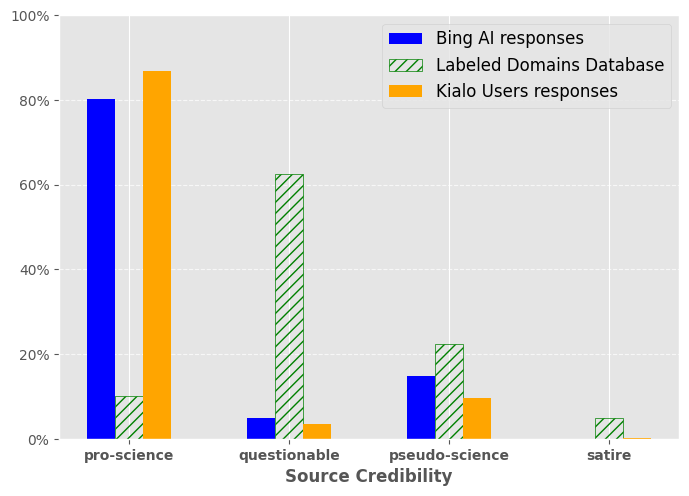

time: 1.55 s (started: 2023-06-01 09:45:08 +00:00)


In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fmt = '%.0f%%' # Define the percentage format
plt.style.use('ggplot')
plt.figure(figsize=(8,4))
# Set x and y data
x = df['x_pos']*2
y1 = df['Labeled Domains Database - percentage']
y2 = df['Bing AI responses - percentage']
y3 = df['Kialo Users responses - percentage']

# Create plot

bar_width = 0.35

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(8,5.5))

# Plot the first set of bars
ax.bar(x-bar_width, y2, bar_width, label='Bing AI responses', color='blue')

ax.bar(x, y1, bar_width, label='Labeled Domains Database',hatch='///',color='none', edgecolor='green')

# Plot the second set of bars next to the first set
ax.bar(x+bar_width, y3, bar_width, label='Kialo Users responses', color='orange')

# Set the x-axis tick labels
ax.set_xticks(x)
ax.set_xticklabels(x)

# # Add a legend to the plot
# ax.legend()

# plt.plot(x, y1,marker='o',linestyle=':',markersize=12,linewidth=3, label='Rated Domains Database',color='green')
# plt.plot(x, y2,marker='o',markersize=12,linewidth=3, label='Bing AI responses', color = 'blue')
# plt.plot(x, y3,marker='o',markersize=12,linewidth=3, label='Kialo Users responses',color = 'orange')

# Add legend and axis labels
plt.legend(fontsize=12)
plt.xlabel('Source Credibility',fontsize=12, fontweight='bold')
# plt.ylabel('Percentage of Total Cited Rated Domains',fontsize=12, fontweight='bold')
plt.xticks(ticks=x, labels=['pro-science','questionable','pseudo-science','satire'],fontsize=10, fontweight='bold')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: fmt % (x * 100)))
plt.ylim([0,1])

tick_colors = [colormap[label] for label in colormap]
plt.tick_params(axis='x', which='major', labelsize=10, bottom=True)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('.../Charts/BarChart-DomainLeaning-Science.png', bbox_inches='tight', format='png', dpi=300)

# Show plot
plt.show()

